In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import string
import re

In [2]:
df = pd.read_csv("train_translated.csv")
texts = df["Context_Indo"].dropna().astype(str).tolist()

In [3]:
stopwords = set([
    "yang", "dan", "di", "ke", "dari", "adalah", "itu", "untuk", "dengan", "saya",
    "kamu", "tidak", "apa", "bagaimana", "kenapa", "mengapa", "ya", "bisa",
    "karena", "jadi", "pada", "oleh", "sebagai", "mereka", "kita", "akan", "dalam"
])

In [4]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords]
    return " ".join(tokens)

In [5]:
cleaned_texts = [clean_text(t) for t in texts]


In [6]:
vectorizer = CountVectorizer(max_df=0.9, min_df=5)
X = vectorizer.fit_transform(cleaned_texts)


In [7]:
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)


LatentDirichletAllocation(n_components=5, random_state=42)

In [30]:
def get_top_words(model, feature_names, n=10, topic_labels=None, return_result=False):
    results = []

    for topic_idx, topic in enumerate(model.components_):
        label = f"Topik {topic_idx + 1}"
        if topic_labels:
            label = f"{label} - {topic_labels.get(topic_idx, '')}"

        print(f"\n🧠 {label}")
        top_indices = topic.argsort()[:-n - 1:-1]
        words_with_weights = [(feature_names[i], round(topic[i], 2)) for i in top_indices]
        for word, weight in words_with_weights:
            print(f"- {word}: {weight}")

        if return_result:
            results.append({
                "Topik": label,
                "Kata_Kunci": words_with_weights
            })

    if return_result:
        return results


In [34]:
topic_labels = {
    0: "Kesehatan Mental",
    1: "Parenting/Keluarga",
    2: "Karier/Motivasi",
    3: "Relasi Sosial",
    4: "Pendidikan"
}

get_top_words(lda, vectorizer.get_feature_names_out(), n=10, topic_labels=topic_labels)


🧠 Topik 1 - Kesehatan Mental
- ini: 642.13
- merasa: 239.8
- seperti: 216.26
- sangat: 194.17
- menjadi: 188.72
- kecemasan: 166.63
- telah: 152.47
- setiap: 149.68
- diri: 146.13
- kali: 144.01

🧠 Topik 2 - Parenting/Keluarga
- orang: 475.35
- hal: 469.55
- tahu: 452.31
- benar: 317.76
- tetapi: 313.29
- harus: 306.02
- atau: 293.67
- ini: 266.35
- telah: 242.93
- apakah: 189.21

🧠 Topik 3 - Karier/Motivasi
- memiliki: 991.82
- tetapi: 429.72
- diri: 412.99
- ini: 391.83
- banyak: 363.64
- masalah: 342.28
- merasa: 329.72
- hidup: 256.03
- orang: 229.95
- pernah: 228.53

🧠 Topik 4 - Relasi Sosial
- dia: 2691.08
- kami: 732.7
- ini: 682.37
- tetapi: 645.8
- telah: 527.12
- benar: 436.98
- ingin: 424.84
- bahwa: 397.97
- tahu: 379.98
- atau: 372.57

🧠 Topik 5 - Pendidikan
- dia: 1747.65
- kami: 534.36
- merasa: 403.32
- anak: 395.46
- tahu: 377.19
- bahwa: 328.17
- ini: 325.31
- ingin: 321.94
- memiliki: 318.38
- pacar: 298.36


In [9]:
import numpy as np

In [10]:
X_transformed = vectorizer.transform(cleaned_texts)


In [11]:
topic_distribution = lda.transform(X_transformed)
predicted_topics = np.argmax(topic_distribution, axis=1)

In [12]:
df["Topik_Prediksi"] = predicted_topics

In [22]:
# Mapping topik ke label deskriptif
label_topik = {
    0: "Kesehatan Mental",
    1: "Parenting/Keluarga",
    2: "Karier/Motivasi",
    3: "Relasi Sosial",
    4: "Pendidikan"
}

# Tambahkan ke DataFrame
df["Label_Topik"] = df["Topik_Prediksi"].map(label_topik)

# Simpan hasil akhir
df.to_csv("data_dengan_label_topik.csv", index=False)
print("File berhasil disimpan sebagai 'data_dengan_label_topik.csv'")


File berhasil disimpan sebagai 'data_dengan_label_topik.csv'


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns


<ipython-input-26-e7a6a52565a9>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topik_counts_label.values, y=topik_counts_label.index, palette="coolwarm")


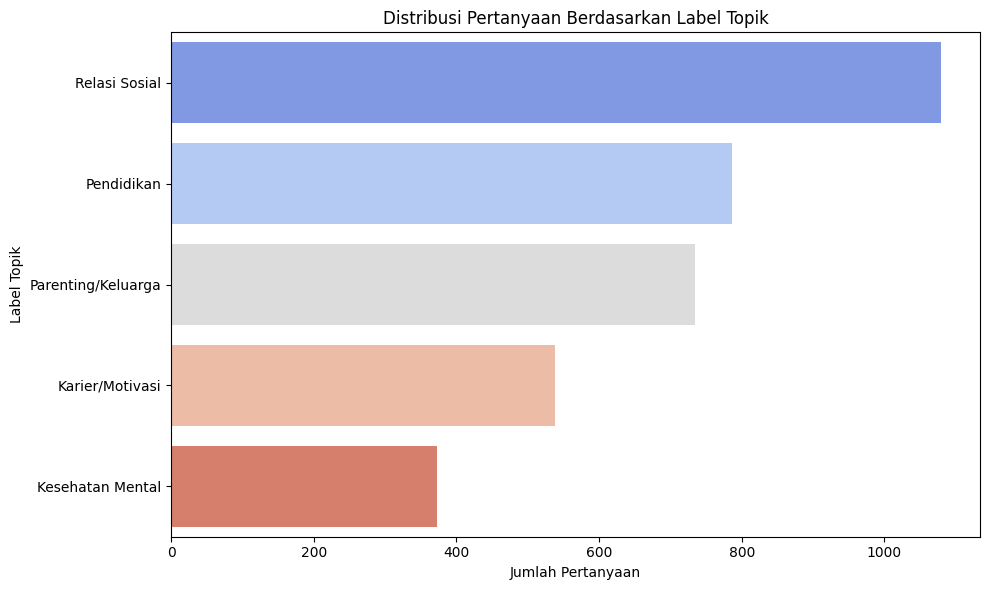

In [26]:
topik_counts_label = df["Label_Topik"].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=topik_counts_label.values, y=topik_counts_label.index, palette="coolwarm")
plt.xlabel("Jumlah Pertanyaan")
plt.ylabel("Label Topik")
plt.title("Distribusi Pertanyaan Berdasarkan Label Topik")
plt.tight_layout()
plt.show()


In [27]:
def get_top_words(model, feature_names, n_top_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"\nTopik {topic_idx + 1}:")
        print(", ".join(top_words))


In [28]:
# Tampilkan 3 contoh pertanyaan per topik
for i in range(5):
    print(f"\n🧠 Contoh untuk Topik {i}:")
    contoh = df[df["Topik_Prediksi"] == i]["Context_Indo"].head(3).tolist()
    for kalimat in contoh:
        print(f"- {kalimat}")



🧠 Contoh untuk Topik 0:
- Saya menderita ADHD dewasa, gangguan kecemasan, dan depresi. Sulit menemukan dokter di daerah saya dan dokter utama saya tidak akan membantu. Saya menganggur dan kewalahan. Apa yang akan Anda sarankan saya lakukan?
- Saya menderita ADHD dewasa, gangguan kecemasan, dan depresi. Sulit menemukan dokter di daerah saya dan dokter utama saya tidak akan membantu. Saya menganggur dan kewalahan. Apa yang akan Anda sarankan saya lakukan?
- Saya menderita ADHD dewasa, gangguan kecemasan, dan depresi. Sulit menemukan dokter di daerah saya dan dokter utama saya tidak akan membantu. Saya menganggur dan kewalahan. Apa yang akan Anda sarankan saya lakukan?

🧠 Contoh untuk Topik 1:
- Saya menghadapi depresi dan kecemasan yang parah dan saya hanya merasa seperti sedang mengalami banyak hal. Ini benar -benar mengalihkan perhatian saya dan saya tidak bisa melepaskan pikiran saya dari hal -hal yang mengganggu saya.    Bagaimana cara mengatasi kecemasan dan depresi ini?
- Saya men